In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft, fftfreq
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os

In [29]:
train_data_path = 'Audio/IRMAS-TrainingData/'
inst_labels = {
    'cel': 0,
    'cla': 1,
    'flu': 2,
    'gac': 3,
    'gel': 4,
    'org': 5,
    'pia': 6,
    'sax': 7,
    'tru': 8,
    'vio': 9,
}
label_inst = { value : key for key, value in inst_labels.items()}
samp_size = 2000
num_harmonics = 30
num_freqs = 100

In [30]:
sample_rate = 0
train_data_audio = {}
for inst in inst_labels.keys():
    print('reading data for ' + inst)
    inst_path = train_data_path + inst + '/'
    files = os.listdir(inst_path)
    train_data_audio[inst] = []
    for f in files:
        sample_rate, samples = wavfile.read(inst_path + f)
        # only use 1 channel audio (mono)
        samples = samples[:, 0]
        train_data_audio[inst].append(samples)


reading data for cel
reading data for cla
reading data for flu
reading data for gac
reading data for gel
reading data for org
reading data for pia
reading data for sax
reading data for tru
reading data for vio


In [4]:
# helper function
def get_levels_max(height, num):
    key_levels = []
    key_idx = []
    bounded_idx = [0]
    num_iter = 0
    height2 = np.copy(height)
    while len(key_levels) < num:
        # get max index of height array
        max_idx = np.argmax(height2)

        # check bounded idxs to see if it is next to a peak
        on_bounded = False
        for b in bounded_idx:
            if max_idx + 1 == b or max_idx - 1 == b or max_idx == b:
                on_bounded = True

        # if its not bounded add to key levels
        if not on_bounded:
            key_levels.append(height[max_idx])
            key_idx.append(max_idx)
        # either way the idx is added to the bounded if its a key level or not
        bounded_idx.append(max_idx)

        # remove from relevance
        height2[max_idx] = 0
        num_iter += 1
        if num_iter > height2.shape[0]:
            # print('brih')
            break
    return key_levels, key_idx

In [5]:
f_min, f_max = 0, 5000
def freq_scaler(arr):
    return [(a - f_min) / (f_max - f_min) for a in arr]

In [6]:
x, y = [], []
freqs = fftfreq(samp_size, 1.0 / sample_rate)
# loop all insts
debug = False
i = 0
for inst, data in train_data_audio.items():
    if i > 0 and debug:
        break
    i += 1
    print('preproccessing ' + inst)
    # loop all audio files
    for sample in data:
        # for each chunk of data in audio file
        for i in range(0, len(sample), samp_size):
            s = sample[i:i+samp_size]
            fft_out = fft(s)
            """
            levels, idx = get_levels_max(np.abs(fft_out), num_harmonics*2)
            maxes = np.array([freqs[i] for i in idx])
            # Add non-repeat frequencies and corrosponding levels into data (size: 20 f + 20 l = 40)
            levs, fs = [], []
            for l, m in zip(levels, maxes):
                if len(levs) == num_harmonics:
                    break
                if abs(m) not in fs:
                    levs.append(l)
                    fs.append(abs(m))
            if (len(levs) == num_harmonics):
                # min-max scale levels data within each sample
                levs = np.array(levs)
                scaler = MinMaxScaler()
                scaler.fit(levs.reshape(-1, 1))
                levs = scaler.transform(levs.reshape(-1, 1))
                levs = list(levs[:, 0])
                # scale frequencies
                fs = freq_scaler(fs)
                # finally add to data
                levs.extend(fs)
                x.append(levs)
            """
            levs = np.array(np.abs(fft_out[:num_freqs]))
            scaler = MinMaxScaler()
            scaler.fit(levs.reshape(-1, 1))
            levs = scaler.transform(levs.reshape(-1, 1))
            levs = list(levs[:, 0])
            x.append(levs)    
            ohc = [0] * len(inst_labels.keys())
            ohc[inst_labels[inst]] = 1
            y.append(ohc)


preproccessing cel
preproccessing cla
preproccessing flu
preproccessing gac
preproccessing gel


In [126]:
x = np.array(x)
x.shape

(183647, 100)

In [127]:
y = np.array(y)
y.shape

(183647, 5)

In [128]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [130]:
# initialize and train model
clf = MLPClassifier(alpha=1e-2, hidden_layer_sizes=(150, 150), random_state=42, solver='adam', verbose=True)
clf.fit(x_train, y_train)

Iteration 1, loss = 2.09122965
Iteration 2, loss = 1.87830980


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(alpha=0.01, hidden_layer_sizes=(150, 150), random_state=42,
              verbose=True)

In [131]:
train_results = clf.predict(x_train)
accuracy_score(y_train, train_results)

0.4044511170576887

In [132]:
test_results = clf.predict(x_test)
accuracy_score(y_test, test_results)

0.3954805336237408

In [80]:
len(freqs)

2000

In [86]:
freqs[:10]

array([  0.  ,  22.05,  44.1 ,  66.15,  88.2 , 110.25, 132.3 , 154.35,
       176.4 , 198.45])

In [88]:
freqs[200]

4410.0

In [6]:
# pre-tensorflow section
import librosa
import librosa.display

preproccessing cel


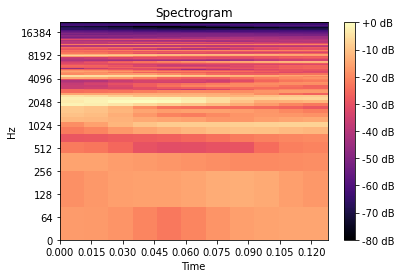

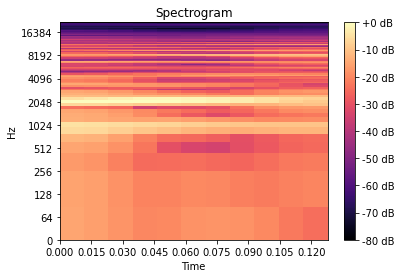

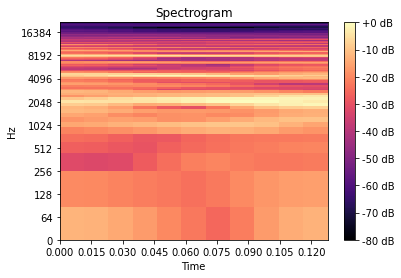

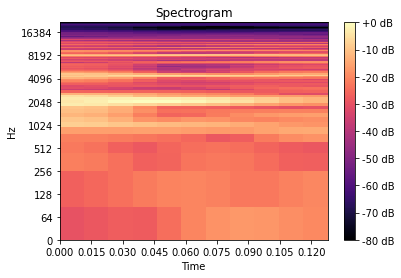

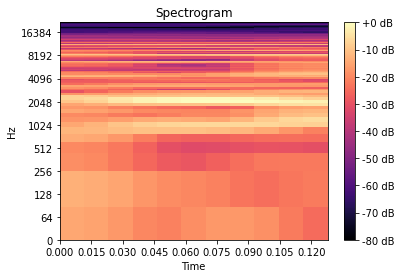

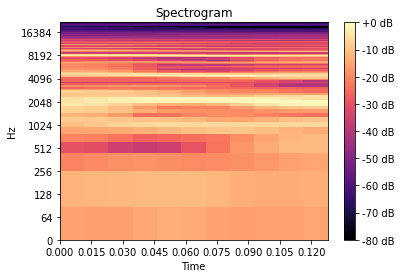

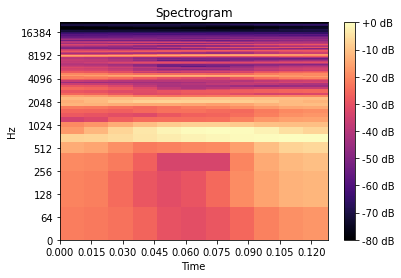

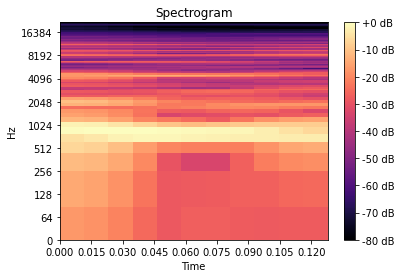

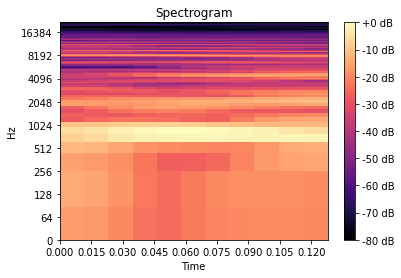

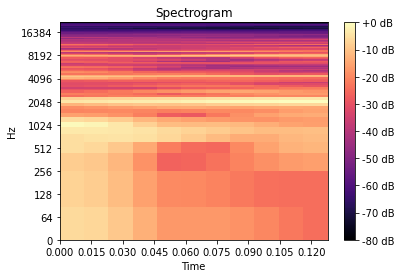

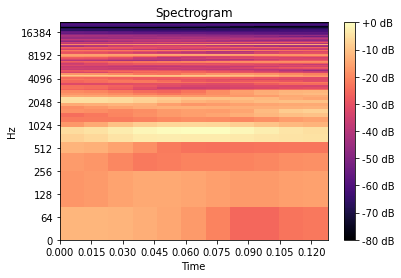

KeyboardInterrupt: 

In [35]:
x, y = [], []
freqs = fftfreq(samp_size, 1.0 / sample_rate)
# loop all insts
debug = False
i = 0
for inst, data in train_data_audio.items():
    if i > 0 and debug:
        break
    i += 1
    print('preproccessing ' + inst)
    # loop all audio files
    for sample in data:
        # for each chunk of data in audio file
        for i in range(0, len(sample), samp_size):
            s = sample[i:i+samp_size]
            if len(s) == samp_size:
                s = np.array([float(si) for si in s])
                mel_spect = librosa.feature.melspectrogram(y=s, sr=sample_rate, n_fft=samp_size, hop_length=200)
                mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
                # print(mel_spect.shape)
                librosa.display.specshow(mel_spect, sr=sample_rate, x_axis='time', y_axis='log');
                plt.colorbar(format='%+2.0f dB');
                plt.title('Spectrogram');
                plt.show()

                x.append(mel_spect)    
                ohc = [0] * len(inst_labels.keys())
                ohc[inst_labels[inst]] = 1
                y.append(ohc)


In [24]:
x.shape

AttributeError: 'list' object has no attribute 'shape'

In [32]:
x = np.array(x)
y = np.array(y)
x.shape, y.shape

((391182, 128, 11), (391182, 10))

In [33]:
d_min, d_max = -100, 0
def dB_scaler(arr):
    return (arr - d_min) / (d_max - d_min)

x = dB_scaler(x)

In [34]:
import joblib
joblib.dump((x, y), 'train_data.joblib')

['train_data.joblib']

In [28]:
x

array([[[0.83268354, 0.82964597, 0.81938089, ..., 0.84545459,
         0.84767989, 0.84782987],
        [0.81472161, 0.8252989 , 0.83935915, ..., 0.85691254,
         0.83913664, 0.82698601],
        [0.84652295, 0.8438914 , 0.83624388, ..., 0.80328244,
         0.80780233, 0.81018968],
        ...,
        [0.26193039, 0.25333251, 0.22586262, ..., 0.2       ,
         0.2       , 0.2       ],
        [0.26468579, 0.25606521, 0.22842199, ..., 0.2       ,
         0.2       , 0.2       ],
        [0.2642314 , 0.25566008, 0.22824786, ..., 0.2       ,
         0.2       , 0.2       ]],

       [[0.84748921, 0.8403124 , 0.82061454, ..., 0.80106665,
         0.77559705, 0.75713592],
        [0.84506578, 0.83752262, 0.81599697, ..., 0.77872309,
         0.78961546, 0.79631793],
        [0.82956224, 0.81993747, 0.78922419, ..., 0.75815207,
         0.7745072 , 0.78079786],
        ...,
        [0.2       , 0.2       , 0.2       , ..., 0.24764908,
         0.27531203, 0.28387679],
        [0.2

In [64]:
def generate_data_from_file(filepath):
    sample_rate, samps = wavfile.read(train_data_path + filepath)
    # only use 1 channel audio (mono)
    samps = samps[:, 0]
    x1 = []
    # for each chunk of data in audio file
    for i in range(0, len(samps), samp_size):
        s = samps[i:i+samp_size]
        if len(s) == samp_size:
            s = np.array([float(si) for si in s])
            mel_spect = librosa.feature.melspectrogram(y=s, sr=sample_rate, n_fft=samp_size, hop_length=200)
            mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
            # print(mel_spect.shape)
            # librosa.display.specshow(mel_spect, sr=sample_rate, x_axis='time', y_axis='log');
            # plt.colorbar(format='%+2.0f dB');
            # plt.title('Spectrogram');
            # plt.show()
            x1.append(mel_spect)
    x1 = np.array(x1)
    x1 = dB_scaler(x1)
    return joblib.dump(x1, filepath[4:-4] + '.joblib')
            
    
    

In [66]:
generate_data_from_file('gac/[gac][pop_roc]0642__2.wav')

['[gac][pop_roc]0642__2.joblib']

In [52]:
tru = joblib.load('[tru][cla]1872__1.joblib')
sax = joblib.load('[sax][cla]1591__3.joblib')
tru

array([[[0.83268354, 0.82964597, 0.81938089, ..., 0.84545459,
         0.84767989, 0.84782987],
        [0.81472161, 0.8252989 , 0.83935915, ..., 0.85691254,
         0.83913664, 0.82698601],
        [0.84652295, 0.8438914 , 0.83624388, ..., 0.80328244,
         0.80780233, 0.81018968],
        ...,
        [0.26193039, 0.25333251, 0.22586262, ..., 0.2       ,
         0.2       , 0.2       ],
        [0.26468579, 0.25606521, 0.22842199, ..., 0.2       ,
         0.2       , 0.2       ],
        [0.2642314 , 0.25566008, 0.22824786, ..., 0.2       ,
         0.2       , 0.2       ]],

       [[0.84748921, 0.8403124 , 0.82061454, ..., 0.80106665,
         0.77559705, 0.75713592],
        [0.84506578, 0.83752262, 0.81599697, ..., 0.77872309,
         0.78961546, 0.79631793],
        [0.82956224, 0.81993747, 0.78922419, ..., 0.75815207,
         0.7745072 , 0.78079786],
        ...,
        [0.2       , 0.2       , 0.2       , ..., 0.24764908,
         0.27531203, 0.28387679],
        [0.2

In [49]:
sax

array([[[-16.73164648, -17.0354026 , -18.0619111 , ..., -15.45454129,
         -15.23201146, -15.21701339],
        [-18.52783882, -17.47011047, -16.06408526, ..., -14.30874573,
         -16.08633611, -17.30139932],
        [-15.34770475, -15.61086008, -16.3756123 , ..., -19.67175604,
         -19.21976691, -18.9810317 ],
        ...,
        [-73.80696149, -74.66674854, -77.41373775, ..., -80.        ,
         -80.        , -80.        ],
        [-73.53142142, -74.39347869, -77.15780084, ..., -80.        ,
         -80.        , -80.        ],
        [-73.57685986, -74.43399197, -77.17521393, ..., -80.        ,
         -80.        , -80.        ]],

       [[-15.25107914, -15.96876022, -17.93854622, ..., -19.89333465,
         -22.44029545, -24.28640805],
        [-15.49342225, -16.24773782, -18.40030334, ..., -22.12769108,
         -21.03845358, -20.36820676],
        [-17.04377631, -18.00625341, -21.07758143, ..., -24.18479269,
         -22.54927993, -21.92021445],
        ...,
